# Find an optimal policy with Finite Markov Decision Process

In this series of Jupyter notebooks, we will learn various methods for finding an optimal policy within the context of Finite Markov Decision Processes (MDPs). 

# Run this Notebook

[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-1-Questions/blob/main/HW1_Notebook.ipynb)

## Series Overview
The series is structured into three parts, each focusing on a different approach for solving MDPs:

**Part 1: Dynamic Programming (This notebook)**

**Part 2: Monte Carlo Methods**

**Part 3: TD Learning**

Let's begin our journey with Part 1: Dynamic Programming.

# Part 1: Dynamic Programming

## What is a Markov Decision Process (MDP)?

In the field of Reinforcement Learning (RL), Markov Decision Processes (MDPs) are fundamental mathematical models used for decision-making in dynamic environments. An MDP consists of several key components:

- **States (S)**: Possible situations or configurations within the environment.

- **Actions (A)**: A set of choices or decisions that an agent can make.

- **Transitions (T)**: Rules or probabilities governing how the environment moves from one state to another after taking a specific action.

- **Rewards (R)**: Immediate numerical values that indicate the desirability of an agent's actions.

- **Discount Factor (γ)**: A factor that balances immediate rewards against future rewards.

The key characteristic of an MDP is that the future state and reward depend only on the current state. 

In this notebook, we will explore the foundational concepts and methods required to identify an optimal strategy for maximizing rewards using Dynamic Programming.


___

In [1]:
!pip install gymnasium[toy_text]

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import LEFT, RIGHT, DOWN, UP
import seaborn as sns
from IPython.display import clear_output


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 22.6 MB/s eta 0:00:0000:0100:01


# Prepare Frozen Lake environment

In this notebook, we will be working with the Frozen Lake environment provided by the Gymnasium framework.

[Learn more about the Frozen Lake environment](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

The objective of this environment is for an agent to navigate through a grid world, starting from the initial cell and reaching the goal cell. Here, we are using a 4x4 grid map, and each cell falls into one of four different categories:

- **S (Start)**: This cell is where our agent begins its journey.

- **F (Frozen)**: These cells are safe for the agent to walk on.

- **H (Hole)**: These are hazardous cells, and if the agent falls into one, the episode terminates with a reward of 0.

- **G (Goal)**: Reaching this cell yields a reward of +1 for the agent.

From the starting cell, the agent has the option to move in four directions: up, left, down, or right. The agent's task is to explore the grid world, making decisions at each time step to eventually reach the goal cell and collect a reward of +1.

In the below code, we can see an example of the agent randomly exploring this environment over 100 time steps.


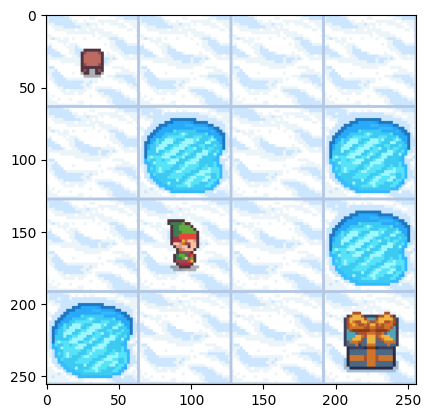

In [2]:
# Create the FrozenLake environment with specific settings
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False, render_mode="rgb_array")

# Reset the environment to its initial state and get the initial observation (initial state)
observation, info = env.reset(seed=2023)
num_state = env.observation_space.n
num_action = env.action_space.n

# Simulate the agent's actions for 100 time steps
for _ in range(100):
    # Choose a random action from the action space
    action = env.action_space.sample()

    # Take the chosen action and observe the resulting state, reward, and termination status
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode is terminated, reset the environment to the start cell
    if terminated:
        observation, info = env.reset()

    # Display the current state of the environment
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

env.close()


In the above exploration, we observed that using random actions rarely leads the agent to the goal state. Now, let's consider a scenario where we have complete knowledge about the environment. Specifically, we have access to information such as the probability of transitioning from one state to another (transition probability) and the rewards associated with each state (reward function). With this knowledge at our hand, how can we determine the optimal policy to guide the agent to its goal? This is the question we aim to address.

Before delving into the algorithms for finding the optimal policy, let's think whether this environment can be classified as a Markov Decision Process (MDP). The Frozen Lake environment indeed falls under the category of MDP because the transition probability and reward function for each state solely depend on the current state, without consideration of past history. For instance, irrespective of how the agent reaches a particular cell—whether it moves left or right or arrives from a left or right cell—the transition probability for the current cell remains consistent. It is not influenced by the agent's previous actions.

Now, you may wonder what characterizes a non-MDP environment. In a non-MDP setting, the reward probability for a given state could change based on the states or the action taken by the agent in previous steps. In such non-MDP environments, it is necessary to maintain a history of states/actions to accurately learn the value for each state. However, since the Frozen Lake environment is MDP, we can focus on the state (or cell) we are currently in and make decisions and learning based on the current state information.


# Policy Evaluation: Finding the Optimal Actions

When we have knowledge of both the transition probability and the reward function, our objective is to learn the optimal action to take at each state to maximize our cumulative reward. In the case of Frozen Lake, this means finding the shortest path to the goal while avoiding pitfalls. (The shortest path has the largest value becasue of the discount factor.)

One approach to achieve this is to explore the state space incrementally, learning in which states we can expect high rewards. In RL, the value of each state is represented by the **State value**, denoted as $V(s)$. How can we calculate the state value?

Here, we learn a fundamental equation in RL used for computing the state value.

### Bellman Expectation Equation

The Bellman Expectation Equation is used to calculate the expected future reward at a particular state under a specific policy. It allows us to compute the state value of each state, and it is defined as follows:

$V^{\pi}(s) = \sum_{a} \pi(a|s) \sum_{s',r} p(s',r|s,a) [r + \gamma V^{\pi}(s')]$

- $V^{\pi}(s)$ represents the value of state $s$ under policy $\pi$.
- $\pi(a|s)$ is the probability of taking action $a$ in state $s$ under policy $\pi$.
- $p(s', r | s, a)$ is the transition probability function, indicating the probability of transitioning to state $s'$ and receiving reward $r$ when taking action $a$ in state $s$.
- $r$ is the immediate reward obtained by taking action $a$ in state $s$.
- $\gamma$ is the discount factor.
- $V^{\pi}(s')$ denotes the value of the next state $s'$ under policy $\pi$.

In our current setup, we have knowledge of the transition probability $p(s', r | s, a)$. With a specific policy $\pi (e.g., random select one of four actions at each state), we can apply an iterative update approach to calculate the state value for each state using the Bellman Expectation Equation. This iterative process is known as policy evaluation, and the pseudocode for this approach is presented in the section below.

### Policy Evaluation with the Bellman Expectation Equation


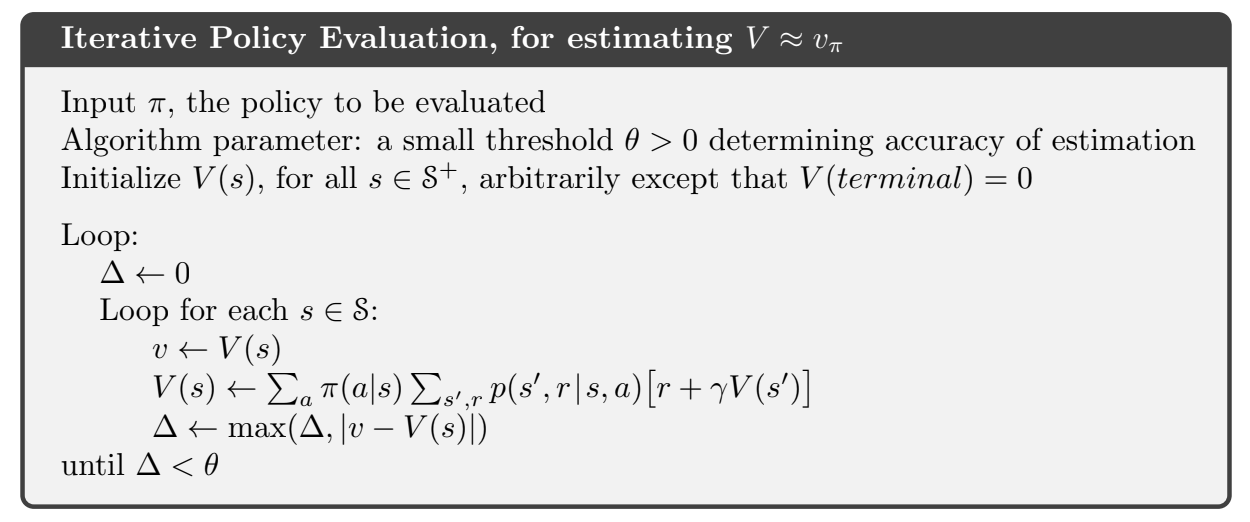

In words, the above pseudocode works as follows:

1. Initialize the state value $V(s)$ with some initial values.
2. Iterate through all states, applying the Bellman Expectation Equation, which uses the transition probability, to update the state value $V(s)$.
3. Calculate the difference between the updated state value and the original state value.
4. Terminate the iteration if the difference is smaller than a specified threshold $\theta$.

In the case of finite Markov Decision Processes (MDP), this iterative approach is guaranteed to converge to the true state value under a given policy, denoted as $V^{\pi}(s)$, due to the Contraction Mapping Theory (the detail of this theory are beyond the scope of this notebook).

Now, let's explore the implementation of policy evaluation using the Bellman Expectation Equation.


In [ ]:
def policy_evaluation(env, policy, value_func, gamma=0.9, max_iterations=int(1e3), tol=1e-3, plot_heatmap=False):
    """
    Perform iterative policy evaluation to estimate the state values.
    """
    # Initialization
    num_state = env.observation_space.n
    num_action = env.action_space.n
    value_func_current = value_func.copy()
    value_func_updated = np.zeros(env.observation_space.n)
    ite = 0
    delta = tol + 0.001  # Add a small value to enter the while loop
    goal_state = (np.where(env.desc.flatten() == b'G'))[0][0]

    # Iterate until delta is smaller than tolerance or reaches the maximum number of iterations
    while (delta > tol) & (ite < max_iterations):
        delta = 0
        for s in range(num_state):
            # If the state is the goal state, do not update the state value (i.e., V(goal_state) = 0)
            if s == goal_state:
                continue

            ttl_value = 0
            a = policy[s]  # Action to take at state s under the policy
            potential_transitions = env.P[s][a]  # Potential next states by taking action a at state s according to the transition probability
            for transition in potential_transitions:
                transition_prob, next_state, reward, is_terminal = transition
                ttl_value += transition_prob * (reward + gamma * value_func_current[next_state])  # Total discounted expected reward with Bellman Equation
            value_func_updated[s] = ttl_value  # Update a state value for s

            # Update delta to check the termination condition
            if delta < (np.abs(value_func_current[s] - value_func_updated[s])):
                delta = np.abs(value_func_current[s] - value_func_updated[s])

            # Store updated state values
            value_func_current = value_func_updated.copy()

        ite += 1

    # Plot value function heatmap
    if plot_heatmap:
        plot_value_func_heatmap(env, value_func_current)
        plt.show()

    return value_func_current, ite


def plot_value_func_heatmap(env, value_func):
    """
    Plot the heatmap of the state values.
    """
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(np.reshape(value_func, [env.nrow, env.ncol]),
                annot=True, linewidths=.5, cmap="GnBu_r", ax=ax,
                yticklabels=np.arange(1, env.nrow + 1)[::-1],
                xticklabels=np.arange(1, env.nrow + 1),
                vmin=0, vmax=1)
    plt.title('State value heatmap', fontsize=15)
    return None


def display_policy_letters(env, policy):
    """
    Display the policy in letter format.
    """
    action_arrows = {LEFT: '←', RIGHT: '→', DOWN: '↓', UP: '↑'}
    policy_letters = []
    for l in policy:
        policy_letters.append(action_arrows[l][0])

    policy_letters = np.array(policy_letters).reshape(env.nrow, env.ncol)

    for row in range(env.nrow):
        print(''.join(policy_letters[row, :]))


Now, let's calculate the state values for three different policies:

1. **Moving left at all states**
2. **Moving right at all states**
3. **Optimal actions**

With the first policy of consistently moving left at all states, we would expect that the agent does not receive any reward. Left actions do not lead to the goal in any cell. Consequently, since the agent doesn't receive any rewards, the state value would be zero for all states under this policy.

Conversely, when we use the second policy of always moving right at all states, we can anticipate receiving a reward at the cell adjacent to the goal state. Consequently, some of the state values will have positive values. 

Let's examine how these values differ when we transition to the optimal actions as our policy.


←←←←
←←←←
←←←←
←←←←


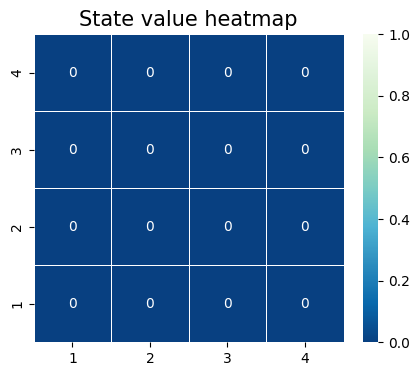

In [4]:
gamma = 0.9

# Policy 1: Always move left
value_func = np.zeros(num_state)
policy = np.array([0] * env.observation_space.n)

# Display the policy in letter format
display_policy_letters(env, policy)

# Perform policy evaluation to calculate state values
value_func, ite = policy_evaluation(env, policy, value_func, gamma, plot_heatmap=True)


→→→→
→→→→
→→→→
→→→→


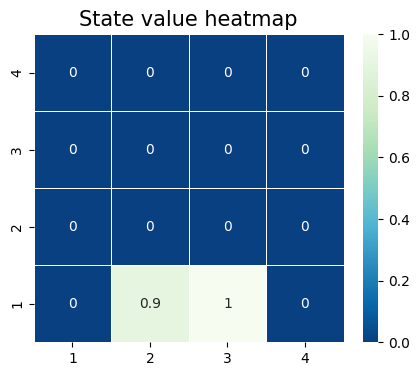

In [5]:
# Policy 2: Always move right
value_func = np.zeros(num_state)
policy = np.array([2]*env.observation_space.n)

# Display the policy in letter format
display_policy_letters(env, policy)

# Perform policy evaluation to calculate state values
value_func, ite = policy_evaluation(env, policy, value_func, gamma, plot_heatmap=True)


↓→↓←
↓←↓←
→↓↓←
←→→←


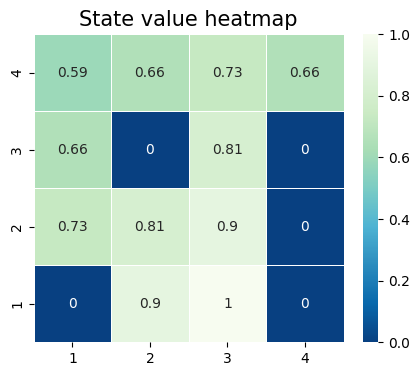

In [6]:
# Policy 3: Optimal actions
value_func = np.zeros(num_state)
policy = [1,2,1,0,1,0,1,0,2,1,1,0,0,2,2,0]

# Display the policy in letter format
display_policy_letters(env, policy)

# Perform policy evaluation to calculate state values
value_func, ite = policy_evaluation(env, policy, value_func, gamma, plot_heatmap=True)


As expected, the state values for the first policy are all zero, while the state values for the second policy contain some positive values. But why does the cell (2,1) also have a positive value in addition to the cell (3,1)? Remember, our state value equation is as follows:

$$V^{\pi}(s) = \sum_{a} \pi(a|s) \sum_{s',r} p(s',r|s,a) [r + \gamma V^{\pi}(s')]$$

The state value is determined by the summation of the immediate reward $r$ and the state value at the next state $V^{\pi}(s')$. So the positive value at cell (2,1) is a result of the positive state value at cell (3,1).

Furthermore, we notice that the optimal policy yields significantly higher state values. These values gradually decrease as we move farther from the goal state due to the presence of the discount factor $\gamma$. For instance, at the starting state, the state value is 0.59 because it takes 5 steps to reach a state with an expected reward of 1, resulting in a discount of $\gamma^6 = 0.59$. Consequently, states closer to the actual reward are valued more than those farther from it.

We have successfully computed the state values for each state. However, we still don't know about how to find the optimal policy for maximizing the total reward, although we manually created it in the above section. Utilizing the state value function computed above, we can actually extract a better policy than the original one by taking actions that lead the agent to states with the maximum state values from each cell. Let's put this to the test.

The code below determines the optimal policy based on the estimated state values with the "move right" policy.


In [7]:
def value_function_to_policy(env, gamma, value_function, num_state, num_action):
    """
    Derive the policy based on the estimated state values using the Bellman Expectation Equation.
    """
    policy = np.zeros(num_state)

    for s in range(num_state):
        act_values = []

        # Compute the expected value of each action a at state s
        for a in range(num_action):
            act_value = 0
            potential_states = env.P[s][a]

            for sub_state in range(len(potential_states)):
                transition_prob, nextstate, reward, is_terminal = env.P[s][a][sub_state]
                act_value += transition_prob * (reward + gamma * value_function[nextstate])

            act_values.append(act_value)

        # Choose an action which has the maximum value and update the policy
        best_actions = np.where(act_values==np.max(act_values))[0] # break a tie
        new_act = np.random.choice(best_actions) # break a tie
        policy[s] = new_act

    return policy


In [8]:
# Estimate the state value with move right policy
value_func = np.zeros(num_state)
policy = np.array([2] * env.observation_space.n)
print('Original policy')
display_policy_letters(env, policy)
value_func, ite = policy_evaluation(env, policy, value_func, gamma, plot_heatmap=False)

# Learn a better policy with the estimated state values
policy = value_function_to_policy(env, gamma, value_func, num_state, num_action)
print('Updated policy')
display_policy_letters(env, policy)


Original policy
→→→→
→→→→
→→→→
→→→→
Updated policy
↓↑↑↓
→↑↑←
↑↓↓←
→→→↑


With the state value updated with move right policy, we extracted an improved policy by taking an action maximizing the value at each state. When the values are the same for multiple actions, an action is randomly chosen to update the policy.

As we observed in the above comparison of the state value estimates for three different policies, the state values vary depending on the policy in use. Thus, the values under this updated policy will be different from the values with move right policy. By iteratively performing policy evaluation and policy update, we will gradually approach the optimal policy. This technique is known as policy iteration.

Below, you'll find a pseudocode outlining the steps of policy iteration.


## Policy iteration

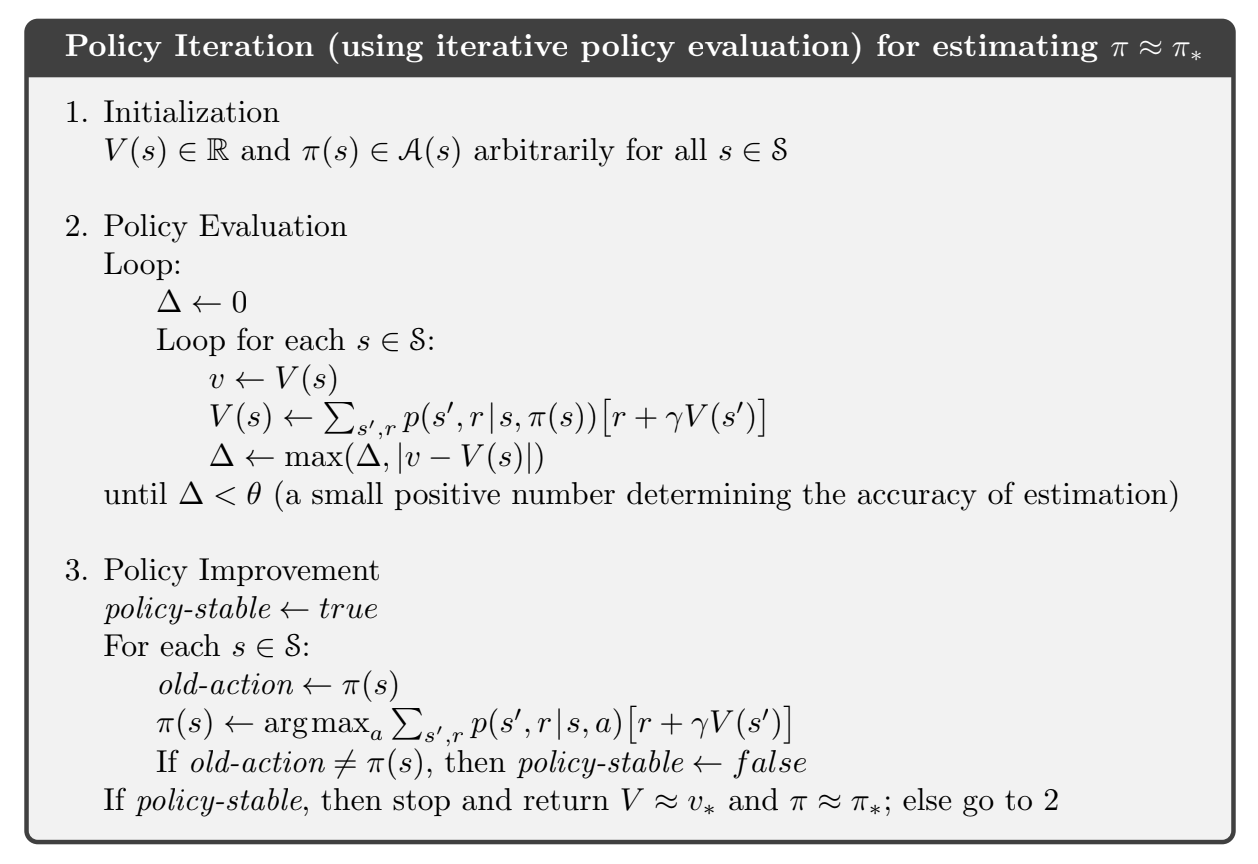

Policy evaluation follows the same principles as what we learned earlier. In words, the above pseudocode works as follows:

1. Complete the policy evaluation process to obtain the state values under the current policy.
2. Iterate through each state and update the action to be taken at each state by selecting the action that maximizes the value of the state.
3. Repeatedly update the policy until it no longer changes from the previous iteration.
4. Once the policy is fully updated, perform policy evaluation again using the updated policy.
5. Repeat these processes in an iterative manner.

Through these iterative policy evaluation and improvement steps, we progressively improve our policy. Similar to policy evaluation, the convergence towards the optimal policy is guaranteed, by the Contraction Mapping Theory. 

Now, let's implement the policy iteration algorithm.


In [9]:
def improve_policy(env, gamma, value_func, policy):
    """
    Improve the policy based on the given state values using the Bellman Expectation Equation.
    """
    # Initialize
    policy_stable = True
    n_state = env.observation_space.n
    n_action = env.action_space.n

    # Iterate all states and update policy
    for s in range(n_state):
        old_act = policy[s]
        act_values = []

        for a in range(n_action):
            act_value = 0
            potential_states = env.P[s][a]

            for sub_state in range(len(potential_states)):
                prob, nextstate, reward, is_terminal = env.P[s][a][sub_state]
                act_value += prob * (reward + gamma * value_func[nextstate])

            act_values.append(act_value)

        # update the policy with the best action
        best_actions = np.where(act_values==np.max(act_values))[0] # break a tie
        new_act = np.random.choice(best_actions) # break a tie
        policy[s] = new_act

        if old_act != new_act:
            policy_stable = False

    return policy_stable, policy


def policy_iteration(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """
    Perform policy iteration to find the optimal policy.
    """
    # Initialization
    policy = np.zeros(env.observation_space.n, dtype='int')
    value_func = np.zeros(env.observation_space.n)
    cnt_policy_improvement = 0
    cnt_ttl_policy_evaluation = 0
    policy_stable = False

    # Iterate until policy will be stable
    while not policy_stable:
        value_func, ite = policy_evaluation(env, policy, value_func)
        policy_stable, policy = improve_policy(env, gamma, value_func, policy)
        cnt_policy_improvement += 1
        cnt_ttl_policy_evaluation += ite

    return policy, value_func, cnt_policy_improvement, cnt_ttl_policy_evaluation


Within the above policy iteration function, the value function is initialized as all zeros and policy is initialized as all left action policy. 
Let's see if this iterative approach can find a optimal policy or not.


↓→↓←
↓↑↓↓
→→↓↑
←→→↓


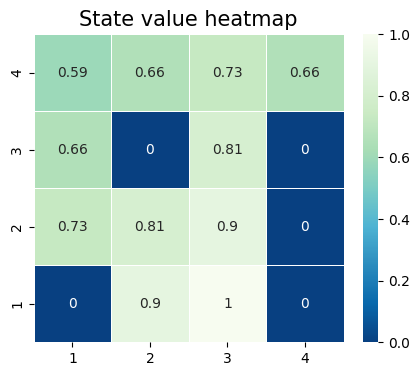

In [10]:
# Perform policy iteration to find the optimal policy
policy, value_func, cnt_policy_improvement, cnt_ttl_policy_evaluation = policy_iteration(env, gamma)

# Plot the heatmap of state values
plot_value_func_heatmap(env, value_func)

# Display the optimal policy in letter format
display_policy_letters(env, policy)


The algorithm converged to the same value function as the value function we found with the optimal policy. The learned policy is also the same as the optimal policy we defined before except differences due to the randomness among equally good actions.

## Value iteration

In RL, there is another crucial equation for computing state values, known as the Bellman Optimality Equation.

## Bellman Optimality Equation

The Bellman Optimality Equation is utilized to determine the optimal action to take at a specific state. It is defined as follows:

$$V^{*}(s) = \max_a \sum_{s',r} p(s',r|s,a) [r + \gamma V^{*}(s')]$$

- $V^{*}(s)$ represents the value of state $s$ under the optimal policy.
- $\max_a$ means selecting the action that maximizes the sum of expected rewards.
- $p(s', r | s, a)$ denotes the transition probability function, indicating the probability of transitioning to state $s'$ and receiving reward $r$ when taking action $a$ in state $s$.
- $r$ denotes the immediate reward.
- $\gamma$ is the discount factor.
- $V^{*}(s')$ represents the value of the next state $s'$ under the optimal policy.

Unlike the Bellman Expectation Equation, which is based on a specific policy $\pi$, the Bellman Optimality Equation calculates values under the optimal policy. The value iteration algorithm offers an iterative approach to discover the optimal value function and policy using the Bellman Optimality Equation.

Below is a pseudocode outlining the value iteration process:


## Value Iteration

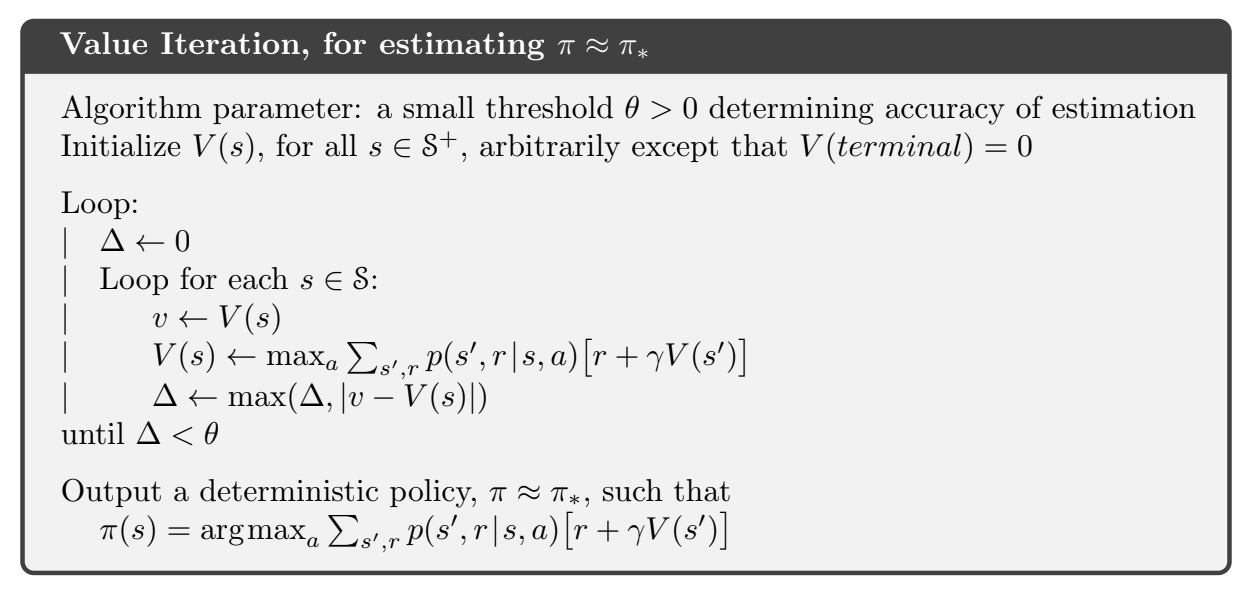

Let's implement and test this algorithm. 

In [11]:
def value_iteration(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """
    Perform value iteration to find the optimal policy and value function.
    """
    # Initialization
    value_func = np.zeros(env.observation_space.n)
    cnt_iteration = 0
    n_state = env.observation_space.n
    n_action = env.action_space.n
    value_func_curr = value_func.copy()
    delta = tol + 0.001

    # Value Iteration
    while (delta > tol) and (cnt_iteration < max_iterations):
        delta = 0
        value_func_new = np.zeros(env.observation_space.n)
        goal_state = (np.where(env.desc.flatten() == b'G'))[0][0]

        for s in range(n_state):
            # No value update at the goal state
            if s == goal_state:
                continue

            max_value = 0

            # Update the value estimate with Bellman Optimality Equation
            for a in range(n_action):
                potential_states = env.P[s][a]

                for sub_state in range(len(potential_states)):
                    prob, nextstate, reward, is_terminal = env.P[s][a][sub_state]
                    curr_value = prob * (reward + gamma * value_func_curr[nextstate])

                    if max_value < curr_value:
                        max_value = curr_value

            value_func_new[s] = max_value

            # Update delta to check the termination condition
            if delta < (np.abs(value_func_curr[s] - value_func_new[s])):
                delta = np.abs(value_func_curr[s] - value_func_new[s])

        value_func_curr = value_func_new.copy()
        cnt_iteration += 1

    value_func = value_func_new

    # Find the optimal policy with the estimated optimal state values
    policy = np.zeros(env.observation_space.n, dtype='int')
    for s in range(n_state):
        old_act = policy[s]
        act_values = []

        for a in range(n_action):
            act_value = 0
            potential_states = env.P[s][a]

            for sub_state in range(len(potential_states)):
                prob, nextstate, reward, is_terminal = env.P[s][a][sub_state]
                act_value += prob * (reward + gamma * value_func[nextstate])

            act_values.append(act_value)
            policy[s] = np.argmax(act_values)

    return value_func, cnt_iteration, policy


↓→↓←
↓←↓←
→↓↓←
←→→←


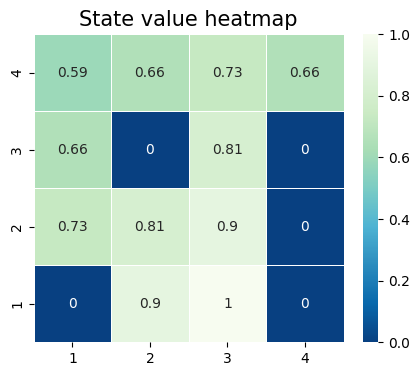

In [12]:
value_func, cnt_iteration, policy = value_iteration(env, gamma)
plot_value_func_heatmap(env, value_func)
display_policy_letters(env, policy)


Both approaches converge to the same value function and policy. However, the choice between the two algorithms depends on the specific scenario. In general, value iteration tends to be more computationally efficient because it involves only one loop to update the value function. Consequently, when dealing with large state or action spaces, value iteration is the preferred choice.

Conversely, in practical applications, policy iteration is more likely to converge to the optimal value and policy functions. Therefore, when you aim for highly accurate estimates and have sufficient computational resources, policy iteration might be a good option.

## Summary

In this notebook, we covered the concepts of policy evaluation, policy iteration, and value iteration, all of which fall under the umbrella of Dynamic Programming. These iterative algorithms rely on having knowledge of the environment's dynamics, specifically the transition function and reward function. However, in real-world scenarios, we often lack precise information about the environment's dynamics. Instead, we aim to learn these dynamics through the agent's interactions and experiences.

In the [next notebook](https://www.kaggle.com/minaiyuki/solving-mdp-using-monte-carlo-methods), we will explore methods for learning the value function and policy directly from the agent's experiences.

### Ref

- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

- https://www.kaggle.com/code/minaiyuki/solving-mdp-using-dynamic-programming
